# Imports

In [133]:
from ultralytics import YOLO
import os
from azure.storage.blob import BlobServiceClient
from pydicom import dcmread
from io import BytesIO
import numpy as np
import cv2
import pylidc as pl
import matplotlib.pyplot as plt

# Helper Functions

## Return ann from slice

In [134]:
# Return annotations
def get_ann_from_slice(patient_id, slice_location):
    # Fetch the scan for the patient
    scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == patient_id).first()
    if not scan:
        raise ValueError(f"No scan found for patient ID {patient_id}")

    # Initialize list to store annotations
    annotations = []

    # Iterate over all annotations in the scan
    for ann in scan.annotations:
        for contour in ann.contours:
            # Check if the annotation is close to the specified slice location
            if abs(contour.image_z_position - slice_location) < scan.slice_spacing:
                annotations.append(ann)
                break

    return annotations

## Returns if model result is positive

In [135]:
def isNodule(result):
    return int(len(result.boxes.xywh.tolist()) > 0)

## Draws BBoxes (pred and label) on sample images and saves in outpath

In [136]:
def draw_boxes(outpath, name, result, ann):
    x_center, y_center, width, height = result.boxes.xywh[0].tolist()

    x1 = int(x_center - width / 2)
    y1 = int(y_center - height / 2)
    x2 = int(x_center + width / 2)
    y2 = int(y_center + height / 2)

    image = result.orig_img
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 1)
    
    if ann != []:
        for a in ann:
            x, y, z = a.centroid
            x = int(x)
            y = int(y)
            cv2.circle(image, (y, x), 15, (0, 0, 255), 1)
    cv2.imwrite(f'{outpath}/{name}.jpg', image)

# Generate Results

## Create arrays that store image_paths (for model) and annotations

In [137]:
path = '/home/andrew/ITRI-LungCancer/sample/'
imgs = os.listdir(path)
imgs.sort()

model_input = []
annotations = []
for i, img in enumerate(imgs):
    patient_id = img.split('_')[0]
    slice_location = float(img.split('_')[-1].split('.')[0])
    
    annotations.append(get_ann_from_slice(patient_id, slice_location))
    model_input.append(path+img)

## Recreate dirs

In [138]:
!rm -rf /home/andrew/ITRI-LungCancer/sample_out
!mkdir -p /home/andrew/ITRI-LungCancer/sample_out

## Draw bboxes on imags and save to outpath
## Create anns and outs arrays that store which slices have annotations

In [139]:
outpath = '/home/andrew/ITRI-LungCancer/sample_out/'

anns = []
outs = []

model = YOLO('/home/andrew/ITRI-LungCancer/YOLO/model_big.pt')
for path, ann in zip(model_input, annotations):
    result = model(path, verbose=False)[0]
    if isNodule(result):
        draw_boxes(outpath, path.split('_')[-2], result, ann)
        outs.append(path.split('_')[1])
        
    if ann != []:
        anns.append(path.split('_')[1])

# Plot outputs against labels

/tmp/ipykernel_57677/3155678946.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


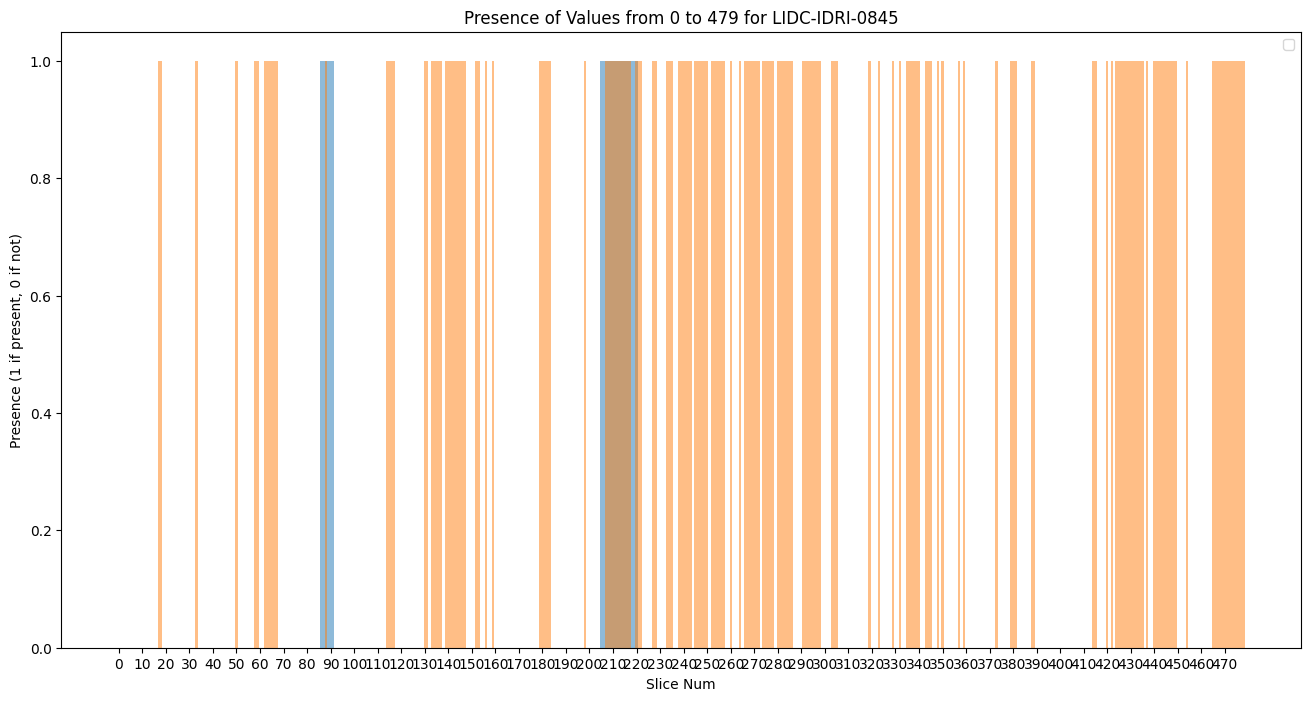

In [140]:
# Convert string values to integers
int_values = [int(value) for value in anns]
int_values2 = [int(value) for value in outs]

# Determines max y value to show on graph
y_max = max(int_values[-1], int_values2[-1]) + 1

# Create an array of zeros for the range 0-200
presence = [0] * y_max
presence2 = [0] * y_max

# Mark presence of each value in the list
for value in int_values:
    presence[value] = 1
    
for value in int_values2:
    presence2[value] = 1

# Plotting
plt.figure(figsize=(16, 8))
plt.bar(range(y_max), presence, width=1.0, alpha=.5)
plt.bar(range(y_max), presence2, width=1.0, alpha=.5)
plt.xlabel('Slice Num')
plt.ylabel('Presence (1 if present, 0 if not)')
patient_id = path.split('_')[0].split('/')[-1]
plt.title(f'Presence of Values from 0 to {y_max} for {patient_id}')
plt.xticks(range(0, y_max, 10))
plt.legend()

plt.show()